In [1]:
import medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO

In [2]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.squeeze().float()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()
                # Display the result
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

In [3]:
def test(model, data_loader, device, convert_to_binary):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()

            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]

        # TODO: Accuracy
        # Calculate accuracy
        correct = (y_preds == y_true[:, 1].long()).sum().item()
        total = y_true.size(0)
        acc = correct / total

        print('Accuracy: %.3f' % (acc))

# Chest

In [4]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
#n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'], "binary-class")

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

Using downloaded and verified file: C:\Users\Sama\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Sama\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\Sama\.medmnist\chestmnist.npz


In [6]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
            
        self.linear1 = nn.Sequential(
            nn.Linear(256, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(2048, 128),
        )
        
        self.classification = nn.Sequential(
            nn.Linear(128, num_classes)
        )
        
        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        if self.extract_embeddings: 
            return x 
        
        x = self.linear1(x)
        x = self.linear2(x)

        x = self.classification(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 22.60it/s]


Epoch: 1	Loss: 0.7127


100%|██████████| 5/5 [00:00<00:00, 26.75it/s]


Epoch: 2	Loss: 0.7264


100%|██████████| 5/5 [00:00<00:00, 28.67it/s]


Epoch: 3	Loss: 0.7326


100%|██████████| 5/5 [00:00<00:00, 29.27it/s]


Epoch: 4	Loss: 0.7188


100%|██████████| 5/5 [00:00<00:00, 29.72it/s]


Epoch: 5	Loss: 0.7340


100%|██████████| 5/5 [00:00<00:00, 28.30it/s]


Epoch: 6	Loss: 0.7163


100%|██████████| 5/5 [00:00<00:00, 32.60it/s]


Epoch: 7	Loss: 0.7068


100%|██████████| 5/5 [00:00<00:00, 28.80it/s]


Epoch: 8	Loss: 0.7309


100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Epoch: 9	Loss: 0.7209


100%|██████████| 5/5 [00:00<00:00, 32.32it/s]


Epoch: 10	Loss: 0.7257


100%|██████████| 5/5 [00:00<00:00, 31.16it/s]


Epoch: 11	Loss: 0.7348


100%|██████████| 5/5 [00:00<00:00, 30.19it/s]


Epoch: 12	Loss: 0.7095


100%|██████████| 5/5 [00:00<00:00, 29.12it/s]


Epoch: 13	Loss: 0.7290


100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


Epoch: 14	Loss: 0.7240


100%|██████████| 5/5 [00:00<00:00, 28.09it/s]


Epoch: 15	Loss: 0.7253


100%|██████████| 5/5 [00:00<00:00, 30.68it/s]


Epoch: 16	Loss: 0.7145


100%|██████████| 5/5 [00:00<00:00, 27.62it/s]


Epoch: 17	Loss: 0.7252


100%|██████████| 5/5 [00:00<00:00, 33.00it/s]


Epoch: 18	Loss: 0.7122


100%|██████████| 5/5 [00:00<00:00, 30.75it/s]


Epoch: 19	Loss: 0.7176


100%|██████████| 5/5 [00:00<00:00, 28.05it/s]

Epoch: 20	Loss: 0.7328


In [7]:
# Assuming train_dataset_chest.labels is a numpy array
labels = train_dataset_chest.labels

# Convert numpy array to PyTorch tensor
labels_tensor = torch.from_numpy(labels).unsqueeze(1)  # Add an extra dimension

# Convert to binary tensor (1 if at least one 1 is present, 0 otherwise)
binary_labels = (labels_tensor.sum(dim=1) > 0).float()

# Calculate the positive rate
positive_rate = binary_labels.mean().item()

# Print the result
print("Positive Rate:", positive_rate)

Positive Rate: 0.05166666582226753


In [8]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
Accuracy: 0.530
test


Accuracy: 0.480


## Latent Space

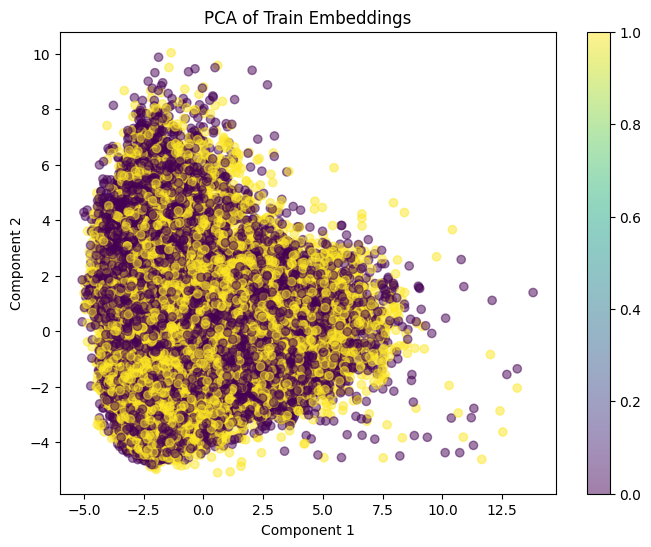

Exception in thread Thread-8:
Traceback (most recent call last):
  File "c:\Users\Sama\anaconda3\envs\AIM_EX1\lib\threading.py", line 950, in _bootstrap_inner
    self.run()
  File "c:\Users\Sama\anaconda3\envs\AIM_EX1\lib\threading.py", line 888, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Sama\anaconda3\envs\AIM_EX1\lib\subprocess.py", line 1475, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\Sama\anaconda3\envs\AIM_EX1\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 3: invalid start byte
c:\Users\Sama\anaconda3\envs\AIM_EX1\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
list index out of range
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cor

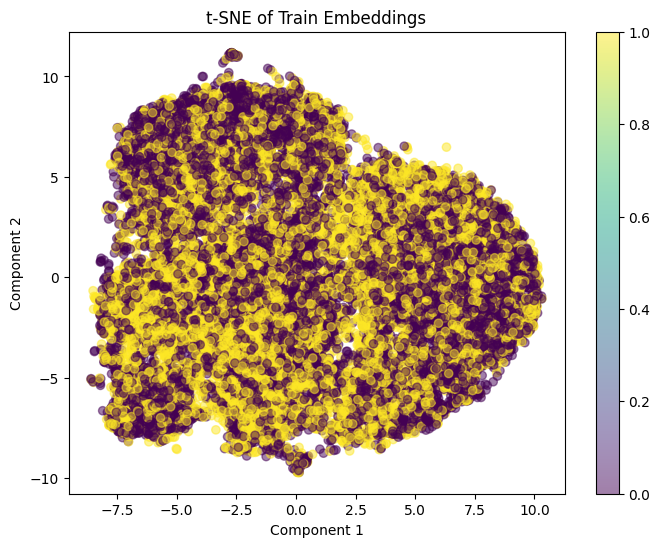

In [9]:
# EXAMINE LATENT SPACE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False
            
            embeddings.append(output)
            labels.append(target)
    
    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest)

# TODO: convert labels to binary
test_labels_binary = test_labels.squeeze().sum(dim=1)
test_labels_binary = (test_labels_binary > 0).float().view(-1, 1)
test_labels = torch.cat([test_labels_binary, 1 - test_labels_binary], dim=1)
test_labels = test_labels[:, 0]

import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TODO: Apply PCA
def apply_pca(embeddings, num_components=2):
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

pca_result = apply_pca(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Apply t-SNE
def apply_tsne(embeddings, num_components=2, perplexity=30, n_iter=300):
    tsne = TSNE(n_components=num_components, perplexity=perplexity, n_iter=n_iter)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result
tsne_result = apply_tsne(test_embeddings_flat)

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


## Autoencoder

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
    
# ===== edited
import os
model_ae_path =  os.path.join('./model', "aeModel.pth")

# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
# ===== edited
    
# TODO: Define an autoencoder model that is compatable with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self, p):
        super(Autoencoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(p),
        )
            
        self.linear1 = nn.Sequential(
            nn.Linear(256, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(p),
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(2048, 128),
        )
        
        self.linear_dec = nn.Sequential(
            nn.Linear(128, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(p),
            nn.Linear(2048, 256),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(256, 128, 4, 3, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(128, 64, 4, 3, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout2d(p),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
        )
        
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear1(x)
        x = self.linear2(x)
        
        x = self.linear_dec(x)
        x = x.view(x.size(0), 256, 1, 1)
        x = self.decoder(x)
        return x
        
# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.05).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

Epoch 1/500, Loss: 0.0708, PSNR: 17.2081, SSIM: 0.4902: 100%|█| 307/307 [01:15<0


Model saved!
Epoch [1/500], Loss: 0.0708, PSNR: 17.2081, SSIM: 0.4902


Epoch 2/500, Loss: 0.0474, PSNR: 19.0182, SSIM: 0.5915: 100%|█| 307/307 [01:07<0


Model saved!
Epoch [2/500], Loss: 0.0474, PSNR: 19.0182, SSIM: 0.5915


Epoch 3/500, Loss: 0.0377, PSNR: 20.0511, SSIM: 0.6366: 100%|█| 307/307 [01:07<0


Model saved!
Epoch [3/500], Loss: 0.0377, PSNR: 20.0511, SSIM: 0.6366


Epoch 4/500, Loss: 0.0281, PSNR: 21.2616, SSIM: 0.6932: 100%|█| 307/307 [01:08<0


Model saved!
Epoch [4/500], Loss: 0.0281, PSNR: 21.2616, SSIM: 0.6932


Epoch 5/500, Loss: 0.0253, PSNR: 21.5696, SSIM: 0.7443: 100%|█| 307/307 [01:09<0


Model saved!
Epoch [5/500], Loss: 0.0253, PSNR: 21.5696, SSIM: 0.7443


Epoch 6/500, Loss: 0.0225, PSNR: 22.1929, SSIM: 0.7074: 100%|█| 307/307 [01:07<0


Model saved!
Epoch [6/500], Loss: 0.0225, PSNR: 22.1929, SSIM: 0.7074


Epoch 7/500, Loss: 0.0232, PSNR: 22.1225, SSIM: 0.7397: 100%|█| 307/307 [01:09<0


Epoch [7/500], Loss: 0.0232, PSNR: 22.1225, SSIM: 0.7397


Epoch 8/500, Loss: 0.0236, PSNR: 21.9394, SSIM: 0.7351: 100%|█| 307/307 [01:14<0


Epoch [8/500], Loss: 0.0236, PSNR: 21.9394, SSIM: 0.7351


Epoch 9/500, Loss: 0.0199, PSNR: 22.8259, SSIM: 0.7791: 100%|█| 307/307 [01:11<0


Model saved!
Epoch [9/500], Loss: 0.0199, PSNR: 22.8259, SSIM: 0.7791


Epoch 10/500, Loss: 0.0176, PSNR: 23.2925, SSIM: 0.7527: 100%|█| 307/307 [01:15<


Model saved!
Epoch [10/500], Loss: 0.0176, PSNR: 23.2925, SSIM: 0.7527


Epoch 11/500, Loss: 0.0166, PSNR: 23.5205, SSIM: 0.7724: 100%|█| 307/307 [01:19<


Model saved!
Epoch [11/500], Loss: 0.0166, PSNR: 23.5205, SSIM: 0.7724


Epoch 12/500, Loss: 0.0188, PSNR: 23.1654, SSIM: 0.7594: 100%|█| 307/307 [01:13<


Epoch [12/500], Loss: 0.0188, PSNR: 23.1654, SSIM: 0.7594


Epoch 13/500, Loss: 0.0161, PSNR: 23.7058, SSIM: 0.7848: 100%|█| 307/307 [01:13<


Model saved!
Epoch [13/500], Loss: 0.0161, PSNR: 23.7058, SSIM: 0.7848


Epoch 14/500, Loss: 0.0146, PSNR: 24.1062, SSIM: 0.7746: 100%|█| 307/307 [01:13<


Model saved!
Epoch [14/500], Loss: 0.0146, PSNR: 24.1062, SSIM: 0.7746


Epoch 15/500, Loss: 0.0144, PSNR: 24.0055, SSIM: 0.7694: 100%|█| 307/307 [01:21<


Model saved!
Epoch [15/500], Loss: 0.0144, PSNR: 24.0055, SSIM: 0.7694


Epoch 16/500, Loss: 0.0160, PSNR: 23.8687, SSIM: 0.7864: 100%|█| 307/307 [01:12<


Epoch [16/500], Loss: 0.0160, PSNR: 23.8687, SSIM: 0.7864


Epoch 17/500, Loss: 0.0128, PSNR: 24.6749, SSIM: 0.7922: 100%|█| 307/307 [01:12<


Model saved!
Epoch [17/500], Loss: 0.0128, PSNR: 24.6749, SSIM: 0.7922


Epoch 18/500, Loss: 0.0126, PSNR: 24.8059, SSIM: 0.8212: 100%|█| 307/307 [01:13<


Model saved!
Epoch [18/500], Loss: 0.0126, PSNR: 24.8059, SSIM: 0.8212


Epoch 19/500, Loss: 0.0140, PSNR: 24.0832, SSIM: 0.8139: 100%|█| 307/307 [01:14<


Epoch [19/500], Loss: 0.0140, PSNR: 24.0832, SSIM: 0.8139


Epoch 20/500, Loss: 0.0125, PSNR: 24.7785, SSIM: 0.8070: 100%|█| 307/307 [01:15<


Model saved!
Epoch [20/500], Loss: 0.0125, PSNR: 24.7785, SSIM: 0.8070


Epoch 21/500, Loss: 0.0115, PSNR: 25.1394, SSIM: 0.8047: 100%|█| 307/307 [01:15<


Model saved!
Epoch [21/500], Loss: 0.0115, PSNR: 25.1394, SSIM: 0.8047


Epoch 22/500, Loss: 0.0115, PSNR: 25.1578, SSIM: 0.8226: 100%|█| 307/307 [01:11<


Epoch [22/500], Loss: 0.0115, PSNR: 25.1578, SSIM: 0.8226


Epoch 23/500, Loss: 0.0133, PSNR: 24.4767, SSIM: 0.8054: 100%|█| 307/307 [01:11<


Epoch [23/500], Loss: 0.0133, PSNR: 24.4767, SSIM: 0.8054


Epoch 24/500, Loss: 0.0117, PSNR: 25.1012, SSIM: 0.8123: 100%|█| 307/307 [01:13<


Epoch [24/500], Loss: 0.0117, PSNR: 25.1012, SSIM: 0.8123


Epoch 25/500, Loss: 0.0104, PSNR: 25.5430, SSIM: 0.8297: 100%|█| 307/307 [01:07<


Model saved!
Epoch [25/500], Loss: 0.0104, PSNR: 25.5430, SSIM: 0.8297


Epoch 26/500, Loss: 0.0110, PSNR: 25.3709, SSIM: 0.8227: 100%|█| 307/307 [01:07<


Epoch [26/500], Loss: 0.0110, PSNR: 25.3709, SSIM: 0.8227


Epoch 27/500, Loss: 0.0102, PSNR: 25.6202, SSIM: 0.8240: 100%|█| 307/307 [01:12<


Model saved!
Epoch [27/500], Loss: 0.0102, PSNR: 25.6202, SSIM: 0.8240


Epoch 28/500, Loss: 0.0103, PSNR: 25.6649, SSIM: 0.8107: 100%|█| 307/307 [01:13<


Epoch [28/500], Loss: 0.0103, PSNR: 25.6649, SSIM: 0.8107


Epoch 29/500, Loss: 0.0094, PSNR: 26.1041, SSIM: 0.8269: 100%|█| 307/307 [01:23<


Model saved!
Epoch [29/500], Loss: 0.0094, PSNR: 26.1041, SSIM: 0.8269


Epoch 30/500, Loss: 0.0100, PSNR: 25.7330, SSIM: 0.8206: 100%|█| 307/307 [01:11<


Epoch [30/500], Loss: 0.0100, PSNR: 25.7330, SSIM: 0.8206


Epoch 31/500, Loss: 0.0099, PSNR: 25.8871, SSIM: 0.8265: 100%|█| 307/307 [01:07<


Epoch [31/500], Loss: 0.0099, PSNR: 25.8871, SSIM: 0.8265


Epoch 32/500, Loss: 0.0100, PSNR: 25.8305, SSIM: 0.8206: 100%|█| 307/307 [01:08<


Epoch [32/500], Loss: 0.0100, PSNR: 25.8305, SSIM: 0.8206


Epoch 33/500, Loss: 0.0089, PSNR: 26.2530, SSIM: 0.8445: 100%|█| 307/307 [01:07<


Model saved!
Epoch [33/500], Loss: 0.0089, PSNR: 26.2530, SSIM: 0.8445


Epoch 34/500, Loss: 0.0098, PSNR: 25.8003, SSIM: 0.8371: 100%|█| 307/307 [01:08<


Epoch [34/500], Loss: 0.0098, PSNR: 25.8003, SSIM: 0.8371


Epoch 35/500, Loss: 0.0090, PSNR: 26.1916, SSIM: 0.8400: 100%|█| 307/307 [01:08<


Epoch [35/500], Loss: 0.0090, PSNR: 26.1916, SSIM: 0.8400


Epoch 36/500, Loss: 0.0092, PSNR: 26.0885, SSIM: 0.8422: 100%|█| 307/307 [01:09<


Epoch [36/500], Loss: 0.0092, PSNR: 26.0885, SSIM: 0.8422


Epoch 37/500, Loss: 0.0095, PSNR: 26.0048, SSIM: 0.8325: 100%|█| 307/307 [01:13<


Epoch [37/500], Loss: 0.0095, PSNR: 26.0048, SSIM: 0.8325


Epoch 38/500, Loss: 0.0089, PSNR: 26.2052, SSIM: 0.8535: 100%|█| 307/307 [01:08<


Epoch [38/500], Loss: 0.0089, PSNR: 26.2052, SSIM: 0.8535


Epoch 39/500, Loss: 0.0083, PSNR: 26.5859, SSIM: 0.8533: 100%|█| 307/307 [01:08<


Model saved!
Epoch [39/500], Loss: 0.0083, PSNR: 26.5859, SSIM: 0.8533


Epoch 40/500, Loss: 0.0091, PSNR: 26.1998, SSIM: 0.8562: 100%|█| 307/307 [01:13<


Epoch [40/500], Loss: 0.0091, PSNR: 26.1998, SSIM: 0.8562


Epoch 41/500, Loss: 0.0094, PSNR: 25.8677, SSIM: 0.8367: 100%|█| 307/307 [01:10<


Epoch [41/500], Loss: 0.0094, PSNR: 25.8677, SSIM: 0.8367


Epoch 42/500, Loss: 0.0097, PSNR: 25.9376, SSIM: 0.8381: 100%|█| 307/307 [01:10<


Epoch [42/500], Loss: 0.0097, PSNR: 25.9376, SSIM: 0.8381


Epoch 43/500, Loss: 0.0079, PSNR: 26.7682, SSIM: 0.8507: 100%|█| 307/307 [01:12<


Model saved!
Epoch [43/500], Loss: 0.0079, PSNR: 26.7682, SSIM: 0.8507


Epoch 44/500, Loss: 0.0092, PSNR: 26.1764, SSIM: 0.8390: 100%|█| 307/307 [01:10<


Epoch [44/500], Loss: 0.0092, PSNR: 26.1764, SSIM: 0.8390


Epoch 45/500, Loss: 0.0084, PSNR: 26.4221, SSIM: 0.8483: 100%|█| 307/307 [01:07<


Epoch [45/500], Loss: 0.0084, PSNR: 26.4221, SSIM: 0.8483


Epoch 46/500, Loss: 0.0085, PSNR: 26.4365, SSIM: 0.8438: 100%|█| 307/307 [01:07<


Epoch [46/500], Loss: 0.0085, PSNR: 26.4365, SSIM: 0.8438


Epoch 47/500, Loss: 0.0085, PSNR: 26.3238, SSIM: 0.8416: 100%|█| 307/307 [01:07<


Epoch [47/500], Loss: 0.0085, PSNR: 26.3238, SSIM: 0.8416


Epoch 48/500, Loss: 0.0084, PSNR: 26.3422, SSIM: 0.8493: 100%|█| 307/307 [01:07<


Epoch [48/500], Loss: 0.0084, PSNR: 26.3422, SSIM: 0.8493


Epoch 49/500, Loss: 0.0083, PSNR: 26.5629, SSIM: 0.8513: 100%|█| 307/307 [01:09<


Epoch [49/500], Loss: 0.0083, PSNR: 26.5629, SSIM: 0.8513


Epoch 50/500, Loss: 0.0078, PSNR: 26.8284, SSIM: 0.8550: 100%|█| 307/307 [01:11<


Model saved!
Epoch [50/500], Loss: 0.0078, PSNR: 26.8284, SSIM: 0.8550


Epoch 51/500, Loss: 0.0088, PSNR: 26.3131, SSIM: 0.8662: 100%|█| 307/307 [01:08<


Epoch [51/500], Loss: 0.0088, PSNR: 26.3131, SSIM: 0.8662


Epoch 52/500, Loss: 0.0084, PSNR: 26.7017, SSIM: 0.8547: 100%|█| 307/307 [01:07<


Epoch [52/500], Loss: 0.0084, PSNR: 26.7017, SSIM: 0.8547


Epoch 53/500, Loss: 0.0081, PSNR: 26.7747, SSIM: 0.8582: 100%|█| 307/307 [01:09<


Epoch [53/500], Loss: 0.0081, PSNR: 26.7747, SSIM: 0.8582


Epoch 54/500, Loss: 0.0079, PSNR: 26.7320, SSIM: 0.8618: 100%|█| 307/307 [01:08<


Epoch [54/500], Loss: 0.0079, PSNR: 26.7320, SSIM: 0.8618


Epoch 55/500, Loss: 0.0076, PSNR: 26.9888, SSIM: 0.8667: 100%|█| 307/307 [01:08<


Model saved!
Epoch [55/500], Loss: 0.0076, PSNR: 26.9888, SSIM: 0.8667


Epoch 56/500, Loss: 0.0078, PSNR: 26.7622, SSIM: 0.8438: 100%|█| 307/307 [01:11<


Epoch [56/500], Loss: 0.0078, PSNR: 26.7622, SSIM: 0.8438


Epoch 57/500, Loss: 0.0073, PSNR: 27.0312, SSIM: 0.8537: 100%|█| 307/307 [01:11<


Model saved!
Epoch [57/500], Loss: 0.0073, PSNR: 27.0312, SSIM: 0.8537


Epoch 58/500, Loss: 0.0075, PSNR: 26.9211, SSIM: 0.8704: 100%|█| 307/307 [01:09<


Epoch [58/500], Loss: 0.0075, PSNR: 26.9211, SSIM: 0.8704


Epoch 59/500, Loss: 0.0076, PSNR: 27.0265, SSIM: 0.8359: 100%|█| 307/307 [01:08<


Epoch [59/500], Loss: 0.0076, PSNR: 27.0265, SSIM: 0.8359


Epoch 60/500, Loss: 0.0074, PSNR: 27.1501, SSIM: 0.8486: 100%|█| 307/307 [01:08<


Epoch [60/500], Loss: 0.0074, PSNR: 27.1501, SSIM: 0.8486


Epoch 61/500, Loss: 0.0079, PSNR: 26.6771, SSIM: 0.8585: 100%|█| 307/307 [01:09<


Epoch [61/500], Loss: 0.0079, PSNR: 26.6771, SSIM: 0.8585


Epoch 62/500, Loss: 0.0068, PSNR: 27.4264, SSIM: 0.8643: 100%|█| 307/307 [01:11<


Model saved!
Epoch [62/500], Loss: 0.0068, PSNR: 27.4264, SSIM: 0.8643


Epoch 63/500, Loss: 0.0073, PSNR: 27.2437, SSIM: 0.8560: 100%|█| 307/307 [01:16<


Epoch [63/500], Loss: 0.0073, PSNR: 27.2437, SSIM: 0.8560


Epoch 64/500, Loss: 0.0077, PSNR: 26.9337, SSIM: 0.8504: 100%|█| 307/307 [01:09<


Epoch [64/500], Loss: 0.0077, PSNR: 26.9337, SSIM: 0.8504


Epoch 65/500, Loss: 0.0077, PSNR: 26.9514, SSIM: 0.8549: 100%|█| 307/307 [01:09<


Epoch [65/500], Loss: 0.0077, PSNR: 26.9514, SSIM: 0.8549


Epoch 66/500, Loss: 0.0072, PSNR: 27.0411, SSIM: 0.8592: 100%|█| 307/307 [01:09<


Epoch [66/500], Loss: 0.0072, PSNR: 27.0411, SSIM: 0.8592


Epoch 67/500, Loss: 0.0071, PSNR: 27.2035, SSIM: 0.8581: 100%|█| 307/307 [01:09<


Epoch [67/500], Loss: 0.0071, PSNR: 27.2035, SSIM: 0.8581


Epoch 68/500, Loss: 0.0069, PSNR: 27.2366, SSIM: 0.8712: 100%|█| 307/307 [01:08<


Epoch [68/500], Loss: 0.0069, PSNR: 27.2366, SSIM: 0.8712


Epoch 69/500, Loss: 0.0078, PSNR: 26.7679, SSIM: 0.8373: 100%|█| 307/307 [01:08<


Epoch [69/500], Loss: 0.0078, PSNR: 26.7679, SSIM: 0.8373


Epoch 70/500, Loss: 0.0068, PSNR: 27.4008, SSIM: 0.8710: 100%|█| 307/307 [01:10<


Model saved!
Epoch [70/500], Loss: 0.0068, PSNR: 27.4008, SSIM: 0.8710


Epoch 71/500, Loss: 0.0080, PSNR: 26.6978, SSIM: 0.8586: 100%|█| 307/307 [01:08<


Epoch [71/500], Loss: 0.0080, PSNR: 26.6978, SSIM: 0.8586


Epoch 72/500, Loss: 0.0071, PSNR: 27.1335, SSIM: 0.8565: 100%|█| 307/307 [01:08<


Epoch [72/500], Loss: 0.0071, PSNR: 27.1335, SSIM: 0.8565


Epoch 73/500, Loss: 0.0068, PSNR: 27.5731, SSIM: 0.8612: 100%|█| 307/307 [01:09<


Epoch [73/500], Loss: 0.0068, PSNR: 27.5731, SSIM: 0.8612


Epoch 74/500, Loss: 0.0074, PSNR: 27.0652, SSIM: 0.8708: 100%|█| 307/307 [01:08<


Epoch [74/500], Loss: 0.0074, PSNR: 27.0652, SSIM: 0.8708


Epoch 75/500, Loss: 0.0069, PSNR: 27.3836, SSIM: 0.8683: 100%|█| 307/307 [01:09<


Epoch [75/500], Loss: 0.0069, PSNR: 27.3836, SSIM: 0.8683


Epoch 76/500, Loss: 0.0069, PSNR: 27.3612, SSIM: 0.8554: 100%|█| 307/307 [01:08<


Epoch [76/500], Loss: 0.0069, PSNR: 27.3612, SSIM: 0.8554


Epoch 77/500, Loss: 0.0068, PSNR: 27.5729, SSIM: 0.8705: 100%|█| 307/307 [01:10<


Epoch [77/500], Loss: 0.0068, PSNR: 27.5729, SSIM: 0.8705


Epoch 78/500, Loss: 0.0071, PSNR: 27.1048, SSIM: 0.8606: 100%|█| 307/307 [01:13<


Epoch [78/500], Loss: 0.0071, PSNR: 27.1048, SSIM: 0.8606


Epoch 79/500, Loss: 0.0064, PSNR: 27.6657, SSIM: 0.8711: 100%|█| 307/307 [01:08<


Model saved!
Epoch [79/500], Loss: 0.0064, PSNR: 27.6657, SSIM: 0.8711


Epoch 80/500, Loss: 0.0070, PSNR: 27.3711, SSIM: 0.8479: 100%|█| 307/307 [01:09<


Epoch [80/500], Loss: 0.0070, PSNR: 27.3711, SSIM: 0.8479


Epoch 81/500, Loss: 0.0073, PSNR: 27.1706, SSIM: 0.8747: 100%|█| 307/307 [01:08<


Epoch [81/500], Loss: 0.0073, PSNR: 27.1706, SSIM: 0.8747


Epoch 82/500, Loss: 0.0079, PSNR: 26.7111, SSIM: 0.8583: 100%|█| 307/307 [01:09<


Epoch [82/500], Loss: 0.0079, PSNR: 26.7111, SSIM: 0.8583


Epoch 83/500, Loss: 0.0071, PSNR: 27.3279, SSIM: 0.8686: 100%|█| 307/307 [01:08<


Epoch [83/500], Loss: 0.0071, PSNR: 27.3279, SSIM: 0.8686


Epoch 84/500, Loss: 0.0075, PSNR: 26.9446, SSIM: 0.8444: 100%|█| 307/307 [01:08<


Epoch [84/500], Loss: 0.0075, PSNR: 26.9446, SSIM: 0.8444


Epoch 85/500, Loss: 0.0071, PSNR: 27.1535, SSIM: 0.8590: 100%|█| 307/307 [01:08<


Epoch [85/500], Loss: 0.0071, PSNR: 27.1535, SSIM: 0.8590


Epoch 86/500, Loss: 0.0078, PSNR: 26.6967, SSIM: 0.8662: 100%|█| 307/307 [01:08<


Epoch [86/500], Loss: 0.0078, PSNR: 26.6967, SSIM: 0.8662


Epoch 87/500, Loss: 0.0069, PSNR: 27.4692, SSIM: 0.8625: 100%|█| 307/307 [01:09<


Epoch [87/500], Loss: 0.0069, PSNR: 27.4692, SSIM: 0.8625


Epoch 88/500, Loss: 0.0066, PSNR: 27.5185, SSIM: 0.8722: 100%|█| 307/307 [01:08<


Epoch [88/500], Loss: 0.0066, PSNR: 27.5185, SSIM: 0.8722


Epoch 89/500, Loss: 0.0073, PSNR: 27.2870, SSIM: 0.8745: 100%|█| 307/307 [01:08<


Epoch [89/500], Loss: 0.0073, PSNR: 27.2870, SSIM: 0.8745


Epoch 90/500, Loss: 0.0064, PSNR: 27.7065, SSIM: 0.8783: 100%|█| 307/307 [01:09<


Model saved!
Epoch [90/500], Loss: 0.0064, PSNR: 27.7065, SSIM: 0.8783


Epoch 91/500, Loss: 0.0070, PSNR: 27.4176, SSIM: 0.8791: 100%|█| 307/307 [01:09<


Epoch [91/500], Loss: 0.0070, PSNR: 27.4176, SSIM: 0.8791


Epoch 92/500, Loss: 0.0067, PSNR: 27.4965, SSIM: 0.8687: 100%|█| 307/307 [01:09<


Epoch [92/500], Loss: 0.0067, PSNR: 27.4965, SSIM: 0.8687


Epoch 93/500, Loss: 0.0067, PSNR: 27.5034, SSIM: 0.8730: 100%|█| 307/307 [01:08<


Epoch [93/500], Loss: 0.0067, PSNR: 27.5034, SSIM: 0.8730


Epoch 94/500, Loss: 0.0070, PSNR: 27.2701, SSIM: 0.8449: 100%|█| 307/307 [01:08<


Epoch [94/500], Loss: 0.0070, PSNR: 27.2701, SSIM: 0.8449


Epoch 95/500, Loss: 0.0066, PSNR: 27.6934, SSIM: 0.8657: 100%|█| 307/307 [01:08<


Epoch [95/500], Loss: 0.0066, PSNR: 27.6934, SSIM: 0.8657


Epoch 96/500, Loss: 0.0079, PSNR: 26.9423, SSIM: 0.8605: 100%|█| 307/307 [01:08<


Epoch [96/500], Loss: 0.0079, PSNR: 26.9423, SSIM: 0.8605


Epoch 97/500, Loss: 0.0073, PSNR: 27.0896, SSIM: 0.8591: 100%|█| 307/307 [01:08<


Epoch [97/500], Loss: 0.0073, PSNR: 27.0896, SSIM: 0.8591


Epoch 98/500, Loss: 0.0065, PSNR: 27.7479, SSIM: 0.8630: 100%|█| 307/307 [01:08<


Epoch [98/500], Loss: 0.0065, PSNR: 27.7479, SSIM: 0.8630


Epoch 99/500, Loss: 0.0061, PSNR: 27.9260, SSIM: 0.8772: 100%|█| 307/307 [01:08<


Model saved!
Epoch [99/500], Loss: 0.0061, PSNR: 27.9260, SSIM: 0.8772


Epoch 100/500, Loss: 0.0063, PSNR: 27.7835, SSIM: 0.8794: 100%|█| 307/307 [01:08


Epoch [100/500], Loss: 0.0063, PSNR: 27.7835, SSIM: 0.8794


Epoch 101/500, Loss: 0.0068, PSNR: 27.4381, SSIM: 0.8644: 100%|█| 307/307 [01:15


Epoch [101/500], Loss: 0.0068, PSNR: 27.4381, SSIM: 0.8644


Epoch 102/500, Loss: 0.0063, PSNR: 27.6602, SSIM: 0.8795: 100%|█| 307/307 [01:14


Epoch [102/500], Loss: 0.0063, PSNR: 27.6602, SSIM: 0.8795


Epoch 103/500, Loss: 0.0068, PSNR: 27.4928, SSIM: 0.8760: 100%|█| 307/307 [01:13


Epoch [103/500], Loss: 0.0068, PSNR: 27.4928, SSIM: 0.8760


Epoch 104/500, Loss: 0.0064, PSNR: 27.6082, SSIM: 0.8734: 100%|█| 307/307 [01:09


Epoch [104/500], Loss: 0.0064, PSNR: 27.6082, SSIM: 0.8734


Epoch 105/500, Loss: 0.0057, PSNR: 28.1244, SSIM: 0.8820: 100%|█| 307/307 [01:08


Model saved!
Epoch [105/500], Loss: 0.0057, PSNR: 28.1244, SSIM: 0.8820


Epoch 106/500, Loss: 0.0070, PSNR: 27.1979, SSIM: 0.8702: 100%|█| 307/307 [01:10


Epoch [106/500], Loss: 0.0070, PSNR: 27.1979, SSIM: 0.8702


Epoch 107/500, Loss: 0.0060, PSNR: 27.8796, SSIM: 0.8812: 100%|█| 307/307 [01:09


Epoch [107/500], Loss: 0.0060, PSNR: 27.8796, SSIM: 0.8812


Epoch 108/500, Loss: 0.0065, PSNR: 27.4486, SSIM: 0.8583: 100%|█| 307/307 [01:09


Epoch [108/500], Loss: 0.0065, PSNR: 27.4486, SSIM: 0.8583


Epoch 109/500, Loss: 0.0081, PSNR: 26.8933, SSIM: 0.8560: 100%|█| 307/307 [01:08


Epoch [109/500], Loss: 0.0081, PSNR: 26.8933, SSIM: 0.8560


Epoch 110/500, Loss: 0.0073, PSNR: 27.1990, SSIM: 0.8618: 100%|█| 307/307 [01:08


Epoch [110/500], Loss: 0.0073, PSNR: 27.1990, SSIM: 0.8618


Epoch 111/500, Loss: 0.0064, PSNR: 27.6641, SSIM: 0.8595: 100%|█| 307/307 [01:10


Epoch [111/500], Loss: 0.0064, PSNR: 27.6641, SSIM: 0.8595


Epoch 112/500, Loss: 0.0062, PSNR: 27.7987, SSIM: 0.8714: 100%|█| 307/307 [01:11


Epoch [112/500], Loss: 0.0062, PSNR: 27.7987, SSIM: 0.8714


Epoch 113/500, Loss: 0.0059, PSNR: 28.0760, SSIM: 0.8836: 100%|█| 307/307 [01:08


Epoch [113/500], Loss: 0.0059, PSNR: 28.0760, SSIM: 0.8836


Epoch 114/500, Loss: 0.0065, PSNR: 27.6124, SSIM: 0.8736: 100%|█| 307/307 [01:08


Epoch [114/500], Loss: 0.0065, PSNR: 27.6124, SSIM: 0.8736


Epoch 115/500, Loss: 0.0070, PSNR: 27.1553, SSIM: 0.8700: 100%|█| 307/307 [01:12


Epoch [115/500], Loss: 0.0070, PSNR: 27.1553, SSIM: 0.8700


Epoch 116/500, Loss: 0.0061, PSNR: 27.7883, SSIM: 0.8778: 100%|█| 307/307 [01:25


Epoch [116/500], Loss: 0.0061, PSNR: 27.7883, SSIM: 0.8778


Epoch 117/500, Loss: 0.0062, PSNR: 27.8294, SSIM: 0.8721: 100%|█| 307/307 [01:16


Epoch [117/500], Loss: 0.0062, PSNR: 27.8294, SSIM: 0.8721


Epoch 118/500, Loss: 0.0066, PSNR: 27.6787, SSIM: 0.8723: 100%|█| 307/307 [01:12


Epoch [118/500], Loss: 0.0066, PSNR: 27.6787, SSIM: 0.8723


Epoch 119/500, Loss: 0.0067, PSNR: 27.4157, SSIM: 0.8696: 100%|█| 307/307 [01:12


Epoch [119/500], Loss: 0.0067, PSNR: 27.4157, SSIM: 0.8696


Epoch 120/500, Loss: 0.0063, PSNR: 27.9255, SSIM: 0.8793: 100%|█| 307/307 [01:14


Epoch [120/500], Loss: 0.0063, PSNR: 27.9255, SSIM: 0.8793


Epoch 121/500, Loss: 0.0062, PSNR: 27.8185, SSIM: 0.8710: 100%|█| 307/307 [01:11


Epoch [121/500], Loss: 0.0062, PSNR: 27.8185, SSIM: 0.8710


Epoch 122/500, Loss: 0.0067, PSNR: 27.4867, SSIM: 0.8664: 100%|█| 307/307 [01:12


Epoch [122/500], Loss: 0.0067, PSNR: 27.4867, SSIM: 0.8664


Epoch 123/500, Loss: 0.0061, PSNR: 27.8571, SSIM: 0.8801: 100%|█| 307/307 [01:12


Epoch [123/500], Loss: 0.0061, PSNR: 27.8571, SSIM: 0.8801


Epoch 124/500, Loss: 0.0066, PSNR: 27.4677, SSIM: 0.8710: 100%|█| 307/307 [01:12


Epoch [124/500], Loss: 0.0066, PSNR: 27.4677, SSIM: 0.8710


Epoch 125/500, Loss: 0.0059, PSNR: 28.0894, SSIM: 0.8782: 100%|█| 307/307 [01:14


Epoch [125/500], Loss: 0.0059, PSNR: 28.0894, SSIM: 0.8782


Epoch 126/500, Loss: 0.0057, PSNR: 28.3442, SSIM: 0.8693: 100%|█| 307/307 [01:11


Model saved!
Epoch [126/500], Loss: 0.0057, PSNR: 28.3442, SSIM: 0.8693


Epoch 127/500, Loss: 0.0068, PSNR: 27.4634, SSIM: 0.8896: 100%|█| 307/307 [01:15


Epoch [127/500], Loss: 0.0068, PSNR: 27.4634, SSIM: 0.8896


Epoch 128/500, Loss: 0.0057, PSNR: 28.1046, SSIM: 0.8810: 100%|█| 307/307 [01:12


Epoch [128/500], Loss: 0.0057, PSNR: 28.1046, SSIM: 0.8810


Epoch 129/500, Loss: 0.0060, PSNR: 28.0980, SSIM: 0.8786: 100%|█| 307/307 [01:12


Epoch [129/500], Loss: 0.0060, PSNR: 28.0980, SSIM: 0.8786


Epoch 130/500, Loss: 0.0064, PSNR: 27.7191, SSIM: 0.8695: 100%|█| 307/307 [01:16


Epoch [130/500], Loss: 0.0064, PSNR: 27.7191, SSIM: 0.8695


Epoch 131/500, Loss: 0.0063, PSNR: 27.7899, SSIM: 0.8743: 100%|█| 307/307 [01:14


Epoch [131/500], Loss: 0.0063, PSNR: 27.7899, SSIM: 0.8743


Epoch 132/500, Loss: 0.0066, PSNR: 27.6383, SSIM: 0.8727: 100%|█| 307/307 [01:12


Epoch [132/500], Loss: 0.0066, PSNR: 27.6383, SSIM: 0.8727


Epoch 133/500, Loss: 0.0058, PSNR: 28.1537, SSIM: 0.8814: 100%|█| 307/307 [01:10


Epoch [133/500], Loss: 0.0058, PSNR: 28.1537, SSIM: 0.8814


Epoch 134/500, Loss: 0.0064, PSNR: 27.6721, SSIM: 0.8682: 100%|█| 307/307 [01:09


Epoch [134/500], Loss: 0.0064, PSNR: 27.6721, SSIM: 0.8682


Epoch 135/500, Loss: 0.0062, PSNR: 27.7815, SSIM: 0.8619: 100%|█| 307/307 [01:12


Epoch [135/500], Loss: 0.0062, PSNR: 27.7815, SSIM: 0.8619


Epoch 136/500, Loss: 0.0058, PSNR: 28.1372, SSIM: 0.8815: 100%|█| 307/307 [01:11


Epoch [136/500], Loss: 0.0058, PSNR: 28.1372, SSIM: 0.8815


Epoch 137/500, Loss: 0.0076, PSNR: 26.8792, SSIM: 0.8611: 100%|█| 307/307 [01:11


Epoch [137/500], Loss: 0.0076, PSNR: 26.8792, SSIM: 0.8611


Epoch 138/500, Loss: 0.0063, PSNR: 27.7831, SSIM: 0.8732: 100%|█| 307/307 [01:11


Epoch [138/500], Loss: 0.0063, PSNR: 27.7831, SSIM: 0.8732


Epoch 139/500, Loss: 0.0066, PSNR: 27.5016, SSIM: 0.8615: 100%|█| 307/307 [01:11


Epoch [139/500], Loss: 0.0066, PSNR: 27.5016, SSIM: 0.8615


Epoch 140/500, Loss: 0.0058, PSNR: 28.0433, SSIM: 0.8804: 100%|█| 307/307 [01:12


Epoch [140/500], Loss: 0.0058, PSNR: 28.0433, SSIM: 0.8804


Epoch 141/500, Loss: 0.0060, PSNR: 28.0900, SSIM: 0.8819: 100%|█| 307/307 [01:16


Epoch [141/500], Loss: 0.0060, PSNR: 28.0900, SSIM: 0.8819


Epoch 142/500, Loss: 0.0057, PSNR: 28.2158, SSIM: 0.8743: 100%|█| 307/307 [01:12


Model saved!
Epoch [142/500], Loss: 0.0057, PSNR: 28.2158, SSIM: 0.8743


Epoch 143/500, Loss: 0.0055, PSNR: 28.5329, SSIM: 0.8864: 100%|█| 307/307 [01:16


Model saved!
Epoch [143/500], Loss: 0.0055, PSNR: 28.5329, SSIM: 0.8864


Epoch 144/500, Loss: 0.0058, PSNR: 28.1309, SSIM: 0.8741: 100%|█| 307/307 [01:12


Epoch [144/500], Loss: 0.0058, PSNR: 28.1309, SSIM: 0.8741


Epoch 145/500, Loss: 0.0073, PSNR: 27.1603, SSIM: 0.8502: 100%|█| 307/307 [01:11


Epoch [145/500], Loss: 0.0073, PSNR: 27.1603, SSIM: 0.8502


Epoch 146/500, Loss: 0.0068, PSNR: 27.3749, SSIM: 0.8575: 100%|█| 307/307 [01:11


Epoch [146/500], Loss: 0.0068, PSNR: 27.3749, SSIM: 0.8575


Epoch 147/500, Loss: 0.0062, PSNR: 27.9604, SSIM: 0.8685: 100%|█| 307/307 [01:11


Epoch [147/500], Loss: 0.0062, PSNR: 27.9604, SSIM: 0.8685


Epoch 148/500, Loss: 0.0054, PSNR: 28.4262, SSIM: 0.8914: 100%|█| 307/307 [01:13


Model saved!
Epoch [148/500], Loss: 0.0054, PSNR: 28.4262, SSIM: 0.8914


Epoch 149/500, Loss: 0.0059, PSNR: 28.1440, SSIM: 0.8738: 100%|█| 307/307 [01:12


Epoch [149/500], Loss: 0.0059, PSNR: 28.1440, SSIM: 0.8738


Epoch 150/500, Loss: 0.0055, PSNR: 28.3146, SSIM: 0.8804: 100%|█| 307/307 [01:12


Epoch [150/500], Loss: 0.0055, PSNR: 28.3146, SSIM: 0.8804


Epoch 151/500, Loss: 0.0057, PSNR: 28.3355, SSIM: 0.8770: 100%|█| 307/307 [01:12


Epoch [151/500], Loss: 0.0057, PSNR: 28.3355, SSIM: 0.8770


Epoch 152/500, Loss: 0.0058, PSNR: 28.0482, SSIM: 0.8735: 100%|█| 307/307 [01:12


Epoch [152/500], Loss: 0.0058, PSNR: 28.0482, SSIM: 0.8735


Epoch 153/500, Loss: 0.0063, PSNR: 27.8103, SSIM: 0.8605: 100%|█| 307/307 [01:12


Epoch [153/500], Loss: 0.0063, PSNR: 27.8103, SSIM: 0.8605


Epoch 154/500, Loss: 0.0059, PSNR: 27.9399, SSIM: 0.8756: 100%|█| 307/307 [01:17


Epoch [154/500], Loss: 0.0059, PSNR: 27.9399, SSIM: 0.8756


Epoch 155/500, Loss: 0.0068, PSNR: 27.6520, SSIM: 0.8731: 100%|█| 307/307 [01:17


Epoch [155/500], Loss: 0.0068, PSNR: 27.6520, SSIM: 0.8731


Epoch 156/500, Loss: 0.0056, PSNR: 28.1641, SSIM: 0.8893: 100%|█| 307/307 [01:10


Epoch [156/500], Loss: 0.0056, PSNR: 28.1641, SSIM: 0.8893


Epoch 157/500, Loss: 0.0060, PSNR: 27.7906, SSIM: 0.8803: 100%|█| 307/307 [01:08


Epoch [157/500], Loss: 0.0060, PSNR: 27.7906, SSIM: 0.8803


Epoch 158/500, Loss: 0.0056, PSNR: 28.2936, SSIM: 0.8825: 100%|█| 307/307 [01:09


Epoch [158/500], Loss: 0.0056, PSNR: 28.2936, SSIM: 0.8825


Epoch 159/500, Loss: 0.0065, PSNR: 27.7316, SSIM: 0.8867: 100%|█| 307/307 [01:12


Epoch [159/500], Loss: 0.0065, PSNR: 27.7316, SSIM: 0.8867


Epoch 160/500, Loss: 0.0055, PSNR: 28.3589, SSIM: 0.8895: 100%|█| 307/307 [01:09


Epoch [160/500], Loss: 0.0055, PSNR: 28.3589, SSIM: 0.8895


Epoch 161/500, Loss: 0.0065, PSNR: 27.7405, SSIM: 0.8747: 100%|█| 307/307 [01:08


Epoch [161/500], Loss: 0.0065, PSNR: 27.7405, SSIM: 0.8747


Epoch 162/500, Loss: 0.0059, PSNR: 28.0066, SSIM: 0.8766: 100%|█| 307/307 [01:08


Epoch [162/500], Loss: 0.0059, PSNR: 28.0066, SSIM: 0.8766


Epoch 163/500, Loss: 0.0062, PSNR: 27.8685, SSIM: 0.8831: 100%|█| 307/307 [01:08


Epoch [163/500], Loss: 0.0062, PSNR: 27.8685, SSIM: 0.8831


Epoch 164/500, Loss: 0.0054, PSNR: 28.2780, SSIM: 0.8859: 100%|█| 307/307 [01:12


Epoch [164/500], Loss: 0.0054, PSNR: 28.2780, SSIM: 0.8859


Epoch 165/500, Loss: 0.0061, PSNR: 27.8871, SSIM: 0.8883: 100%|█| 307/307 [01:16


Epoch [165/500], Loss: 0.0061, PSNR: 27.8871, SSIM: 0.8883


Epoch 166/500, Loss: 0.0059, PSNR: 28.0027, SSIM: 0.8793: 100%|█| 307/307 [01:10


Epoch [166/500], Loss: 0.0059, PSNR: 28.0027, SSIM: 0.8793


Epoch 167/500, Loss: 0.0060, PSNR: 27.9868, SSIM: 0.8785: 100%|█| 307/307 [01:09


Epoch [167/500], Loss: 0.0060, PSNR: 27.9868, SSIM: 0.8785


Epoch 168/500, Loss: 0.0058, PSNR: 28.0797, SSIM: 0.8760: 100%|█| 307/307 [01:08


Epoch [168/500], Loss: 0.0058, PSNR: 28.0797, SSIM: 0.8760


Epoch 169/500, Loss: 0.0055, PSNR: 28.3451, SSIM: 0.8878: 100%|█| 307/307 [01:10


Average Test Loss: 0.0001, Average PSNR: 28.7959, Average SSIM: 0.8961


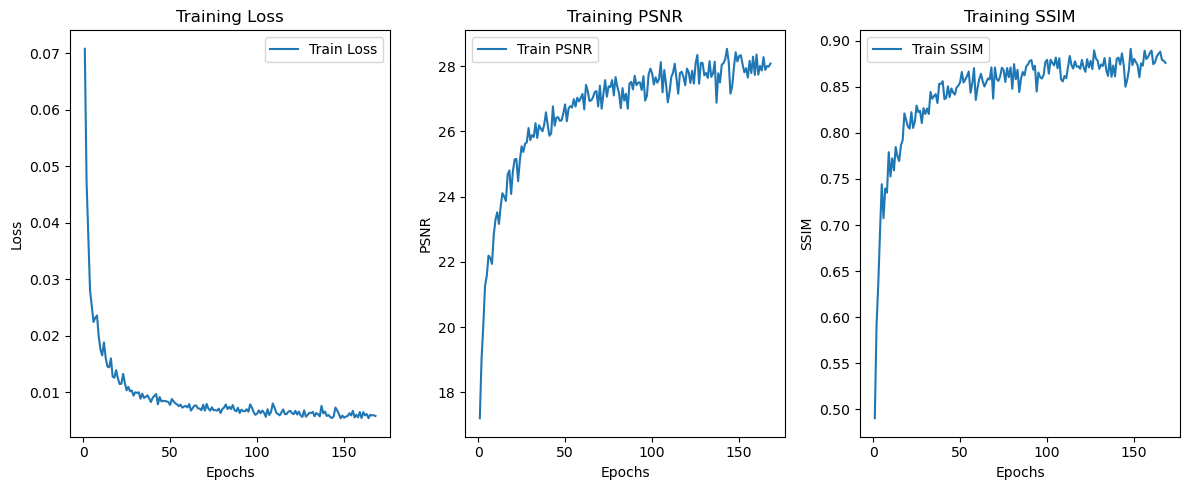

In [11]:
# ===== edited
train_losses = []
train_psnrs = []
train_ssims = []
best_loss = 10
best_epoch = -1
patience = 20
# ===== edited

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model_ae.train()

    # ===== edited
    tqdm_train_loader = tqdm(train_loader_chest_full, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)
    # ===== edited
    
    for x in tqdm_train_loader:
        inputs, _ = x
        inputs = inputs.to(device)
        
        # Forward pass
        outputs = model_ae(inputs)
        loss = criterion_ae(outputs, inputs)
        
        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)
            
        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        
        # ===== edited
        tqdm_train_loader.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    tqdm_train_loader.close()   
        
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        torch.save(model_ae.state_dict(), model_ae_path)
        print(f'Model saved!')
    if (epoch - best_epoch) > patience:
        break
        
    train_losses.append(loss.item())
    train_psnrs.append(psnr_value.item())
    train_ssims.append(ssim_value.item())
    # ===== edited
    
    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')

# ===== edited
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_psnrs, label='Train PSNR')
plt.title('Training PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_ssims, label='Train SSIM')
plt.title('Training SSIM')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()

plt.tight_layout()
plt.show()
# ===== edited

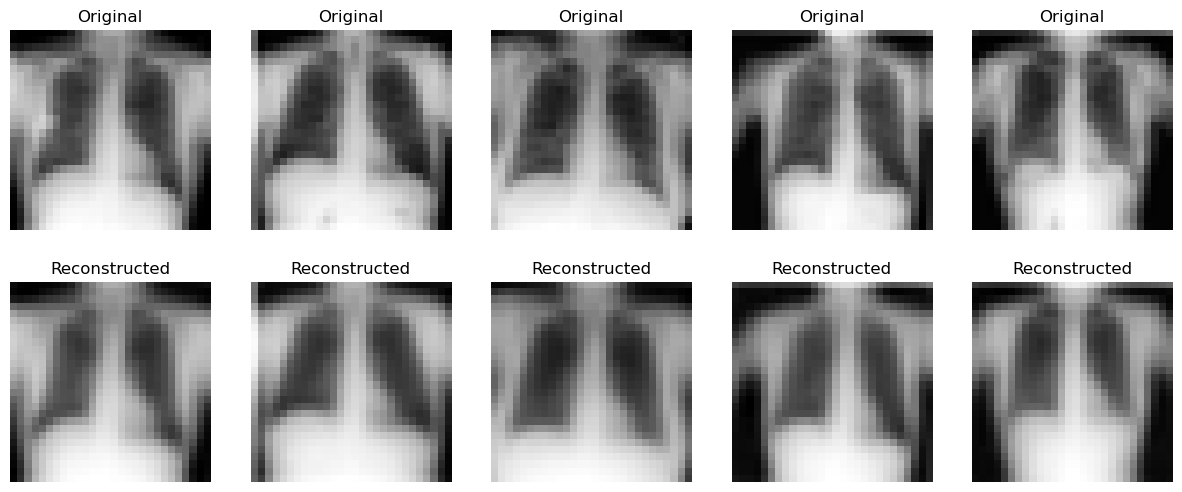

In [12]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# ===== edited
model_ae.load_state_dict(torch.load(model_ae_path))
# ===== edited

# TODO: Function to plot input and output images
def plot_images(model, test_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)

            # Forward pass through the autoencoder
            outputs = model(inputs)

            # Plot the original and reconstructed images
            plt.figure(figsize=(15, 6))
            for i in range(min(inputs.size(0), num_images)):
                # Original Image
                plt.subplot(2, num_images, i + 1)
                plt.imshow(inputs[i][0].cpu().numpy(), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                # Reconstructed Image
                plt.subplot(2, num_images, i + num_images + 1)
                plt.imshow(outputs[i][0].cpu().numpy(), cmap='gray')
                plt.title('Reconstructed')
                plt.axis('off')

            plt.show()
            break  # Show only the first batch

# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [14]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model
model_transfer_dict = model_transfer.state_dict()
model_ae_dict = torch.load(model_ae_path)
model_ae_dict_filtered = {k: v for k, v in model_ae_dict.items() if k in model_transfer_dict}

'''
from itertools import zip_longest
for key1, key2, key3 in zip_longest(model_transfer_dict.keys(), model_ae_dict.keys(), model_ae_dict_filtered.keys(), fillvalue=''):
    print(f'{key1: >35} --- {key2: >35} --- {key3: >35}')
'''

model_transfer_dict.update(model_ae_dict_filtered)
model_transfer.load_state_dict(model_transfer_dict)

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=100, device=device)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.76it/s]


Epoch: 1	Loss: 0.6846


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 70.93it/s]


Epoch: 2	Loss: 0.6887


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 66.15it/s]


Epoch: 3	Loss: 0.6815


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 64.63it/s]


Epoch: 4	Loss: 0.6989


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 61.75it/s]


Epoch: 5	Loss: 0.6855


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 59.74it/s]


Epoch: 6	Loss: 0.6925


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 65.53it/s]


Epoch: 7	Loss: 0.6892


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.94it/s]


Epoch: 8	Loss: 0.6901


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.79it/s]


Epoch: 9	Loss: 0.6836


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 58.48it/s]


Epoch: 10	Loss: 0.6984


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 64.93it/s]


Epoch: 11	Loss: 0.6939


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.20it/s]


Epoch: 12	Loss: 0.6905


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 65.20it/s]


Epoch: 13	Loss: 0.6920


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.86it/s]


Epoch: 14	Loss: 0.6878


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 59.97it/s]


Epoch: 15	Loss: 0.6955


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.55it/s]


Epoch: 16	Loss: 0.7002


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.47it/s]


Epoch: 17	Loss: 0.6901


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 33.17it/s]


Epoch: 18	Loss: 0.6907


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 24.69it/s]


Epoch: 19	Loss: 0.7039


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 40.37it/s]


Epoch: 20	Loss: 0.6864


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 39.03it/s]


Epoch: 21	Loss: 0.7024


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 41.87it/s]


Epoch: 22	Loss: 0.6864


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 32.16it/s]


Epoch: 23	Loss: 0.6916


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.31it/s]


Epoch: 24	Loss: 0.6862


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.86it/s]


Epoch: 25	Loss: 0.6896


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.16it/s]


Epoch: 26	Loss: 0.6868


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.01it/s]


Epoch: 27	Loss: 0.6909


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.17it/s]


Epoch: 28	Loss: 0.6865


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.86it/s]


Epoch: 29	Loss: 0.6950


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.59it/s]


Epoch: 30	Loss: 0.6939


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 49.42it/s]


Epoch: 31	Loss: 0.6880


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 59.55it/s]


Epoch: 32	Loss: 0.6935


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.39it/s]


Epoch: 33	Loss: 0.6948


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 40.37it/s]


Epoch: 34	Loss: 0.6891


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 33.80it/s]


Epoch: 35	Loss: 0.6861


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 47.74it/s]


Epoch: 36	Loss: 0.6993


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 54.90it/s]


Epoch: 37	Loss: 0.6892


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.18it/s]


Epoch: 38	Loss: 0.6989


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 49.38it/s]


Epoch: 39	Loss: 0.6820


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 40.59it/s]


Epoch: 40	Loss: 0.7019


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.21it/s]


Epoch: 41	Loss: 0.6960


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 57.10it/s]


Epoch: 42	Loss: 0.6880


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.59it/s]


Epoch: 43	Loss: 0.6999


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 55.22it/s]


Epoch: 44	Loss: 0.6864


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 59.42it/s]


Epoch: 45	Loss: 0.6833


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 45.99it/s]


Epoch: 46	Loss: 0.6931


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 42.83it/s]


Epoch: 47	Loss: 0.6853


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.79it/s]


Epoch: 48	Loss: 0.6919


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.19it/s]


Epoch: 49	Loss: 0.6854


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.73it/s]


Epoch: 50	Loss: 0.6972


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.18it/s]


Epoch: 51	Loss: 0.6953


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 42.30it/s]


Epoch: 52	Loss: 0.7018


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.13it/s]


Epoch: 53	Loss: 0.6833


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.69it/s]


Epoch: 54	Loss: 0.6939


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 69.39it/s]


Epoch: 55	Loss: 0.6944


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.41it/s]


Epoch: 56	Loss: 0.6853


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.91it/s]


Epoch: 57	Loss: 0.6927


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.06it/s]


Epoch: 58	Loss: 0.6946


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 44.16it/s]


Epoch: 59	Loss: 0.6867


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 52.18it/s]


Epoch: 60	Loss: 0.6961


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 57.56it/s]


Epoch: 61	Loss: 0.6930


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 40.88it/s]


Epoch: 62	Loss: 0.7011


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 43.85it/s]


Epoch: 63	Loss: 0.6960


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 32.73it/s]


Epoch: 64	Loss: 0.6901


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 33.73it/s]


Epoch: 65	Loss: 0.6888


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 39.54it/s]


Epoch: 66	Loss: 0.6945


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.85it/s]


Epoch: 67	Loss: 0.6979


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 57.08it/s]


Epoch: 68	Loss: 0.6965


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 66.79it/s]


Epoch: 69	Loss: 0.6839


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 72.19it/s]


Epoch: 70	Loss: 0.6783


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 75.96it/s]


Epoch: 71	Loss: 0.6877


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.72it/s]


Epoch: 72	Loss: 0.6829


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 54.96it/s]


Epoch: 73	Loss: 0.6759


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 47.20it/s]


Epoch: 74	Loss: 0.6912


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 35.07it/s]


Epoch: 75	Loss: 0.6864


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 43.55it/s]


Epoch: 76	Loss: 0.6894


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.50it/s]


Epoch: 77	Loss: 0.6959


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.28it/s]


Epoch: 78	Loss: 0.6963


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 53.79it/s]


Epoch: 79	Loss: 0.6936


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.44it/s]


Epoch: 80	Loss: 0.6935


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.15it/s]


Epoch: 81	Loss: 0.6889


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 49.48it/s]


Epoch: 82	Loss: 0.6920


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 50.34it/s]


Epoch: 83	Loss: 0.6942


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 67.85it/s]


Epoch: 84	Loss: 0.6973


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.47it/s]


Epoch: 85	Loss: 0.6924


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 62.74it/s]


Epoch: 86	Loss: 0.6978


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 52.00it/s]


Epoch: 87	Loss: 0.6937


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 51.53it/s]


Epoch: 88	Loss: 0.7048


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 38.71it/s]


Epoch: 89	Loss: 0.6931


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 38.09it/s]


Epoch: 90	Loss: 0.6988


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 52.29it/s]


Epoch: 91	Loss: 0.6866


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 63.51it/s]


Epoch: 92	Loss: 0.6909


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.40it/s]


Epoch: 93	Loss: 0.6941


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 68.71it/s]


Epoch: 94	Loss: 0.6909


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 55.65it/s]


Epoch: 95	Loss: 0.6888


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 66.94it/s]


Epoch: 96	Loss: 0.6912


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 60.74it/s]


Epoch: 97	Loss: 0.7007


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 48.01it/s]


Epoch: 98	Loss: 0.6890


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 45.09it/s]


Epoch: 99	Loss: 0.6888


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 51.05it/s]

Epoch: 100	Loss: 0.6896


In [15]:
print('==> Evaluating ...')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
Accuracy: 0.533
Accuracy: 0.524


# Pneumonia

In [13]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.squeeze().long()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()
                # Display the result

            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

def test(model, data_loader, device, convert_to_binary):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()

            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]

        # TODO: Accuracy
        # Calculate accuracy
        correct = (y_preds == y_true).sum().item()
        total = y_true.size(0)
        acc = correct / total
        print('Accuracy: %.3f' % (acc))

In [10]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

Using downloaded and verified file: C:\Users\Sama\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Sama\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Sama\.medmnist\pneumoniamnist.npz


In [11]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [14]:
# train

model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:07<00:00,  9.50it/s]


Epoch: 1	Loss: 0.2206


100%|██████████| 74/74 [00:09<00:00,  8.21it/s]


Epoch: 2	Loss: 0.0793


100%|██████████| 74/74 [00:08<00:00,  8.87it/s]


Epoch: 3	Loss: 0.0447


100%|██████████| 74/74 [00:07<00:00,  9.39it/s]


Epoch: 4	Loss: 0.0264


100%|██████████| 74/74 [00:07<00:00,  9.33it/s]


Epoch: 5	Loss: 0.0140


100%|██████████| 74/74 [00:08<00:00,  8.47it/s]


Epoch: 6	Loss: 0.0106


100%|██████████| 74/74 [00:08<00:00,  8.92it/s]


Epoch: 7	Loss: 0.0072


100%|██████████| 74/74 [00:08<00:00,  9.08it/s]


Epoch: 8	Loss: 0.0051


100%|██████████| 74/74 [00:07<00:00,  9.30it/s]


Epoch: 9	Loss: 0.0036


100%|██████████| 74/74 [00:07<00:00,  9.40it/s]


Epoch: 10	Loss: 0.0037


In [15]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
Accuracy: 1.000
test
Accuracy: 0.840


## Transfer learning

In [16]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 307/307 [00:39<00:00,  7.70it/s]


Epoch: 1	Loss: 0.7455


 41%|████      | 125/307 [00:16<00:27,  6.53it/s]

### Transfer learning - Frozen

In [ ]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model

for k, v in model_chest_full.state_dict().items():
    if 'fc' not in k:
        model_pneumonia_transfer_frozen.state_dict()[k] = v

# TODO: Freeze all layers except the FC
for param in model_pneumonia_transfer_frozen.parameters():
    param.requires_grad = False

# Unfreeze the fully connected layers
for param in model_pneumonia_transfer_frozen.fc.parameters():
    param.requires_grad = True
# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca_result = apply_pca(test_embeddings_flat)
# TODO: Apply t-SNE
tsne_result = apply_tsne(test_embeddings_flat)
# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model
model_pneumonia_transfer_frozen.load_state_dict(model_chest_full.state_dict())
# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca_result = apply_pca(test_embeddings_flat)
# TODO: Apply t-SNE
tsne_result = apply_tsne(test_embeddings_flat)
# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### BONUS: Transfer learning 